# Collaboration and Competition

This project entails training 2 agents to maintain a table tennis game. A reward of +0.1 is given if the agent is successfully hit the ball over the net. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01 instead. Therefore the goal of these 2 agents is to keep the ball in play as long as possible.

#### 1. Import Packages

The following imports are necessary in order to run the environment and train the agent. The agent built to solve this the given task is based on DDPG (Deep Deterministic Policy Gradient) method. However, since there are two agents playing within the environment, a method known as Multi Agent DDPG (MADDPG) is used. This simply means the DDPG algorithm will be training more than one agent at a time.

In [8]:
from unityagents import UnityEnvironment
from collections import deque
from maddpgtennis import DDPG, ReplayBuffer, MADDPG

import matplotlib.pyplot as plt
import numpy as np
import torch
import time as t_

#### 2. Setting Up Environment

The environment is provided by UnityEnvironment called Reacher.exe. This file is saved under the folder `Tennis_Windows_x86_64/Tennis.exe` since all of the training is done on a Windows 64-bit machine. The graphics is disabled during the training. Next, the brain of the environment is set before resetting the environment prior to exploring and/or training. 

The following information, however, is important to note:

The following describes the Tennis environment.

1. The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket
2. Each agent receives its own local observations
3. Two continuous actions are available, corresponding to movement towards or away from the net and jumping

In [2]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe', no_graphics=True)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)
n_action = brain.vector_action_space_size
print('Size of each action:', n_action)
states = env_info.vector_observations
n_state = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], n_state))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


The MADDPG agent is trained on the environment with 2 agents.

Both of these agents will have the following neural network architecture:

1. Actor Network
    - `hidden_layer_1 = 256`, with `ReLU` activation function
    - `hidden_layer_2 = 128`, with `ReLU` activation function
    - `output_layer`, with `tanh` activation function
    
2. Critic Network
    - `hidden_layer_1 = 256`, with `ReLU` activation function
    - `hidden_layer_2 = 128`, with `ReLU` activation function
    - `output_layer`, without activation function

In [3]:
ma_ddpg = MADDPG(n_state=n_state, n_action=n_action, n_agents=n_agents)

#### 3. Define model_train() Function to Train the Agent

The following function is written to train the agent through a series of episodes. The total number of episodes is set to be 5000, with no maximum steps per episode (termination only occurs when the environment is no longer running that particular episode). 

The scores for each episode is recorded at the end of every loop. The stopping criteria of the agent trained is an average score of 0.5 or more for the past 100 consecutive episodes where the maximum score between the two agents is the one considered. This average score is stored within a list of avg_scores with maximum length of deque as 100. 

The function returns both the scores list and average scores list (to be plotted later).

In [4]:
def model_train(num_episodes=5000, n_agents=n_agents):
    avg_scores = deque(maxlen=100)
    scores = []
    avg_100 = []
    counter = 0
    for episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(n_agents)
        start = t_.time()
        while True:
            # take actions
            sel_actions = ma_ddpg.action_(states)
            act_ = torch.stack(sel_actions).cpu().detach()
            actions = np.clip(act_.numpy(), -1, 1)
            # update the environment
            env_info = env.step(actions)[brain_name]
            states_ = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            # step and check if agent can learn
            ma_ddpg.step(states, act_, rewards, states_, dones)
            # reassign states and add rewards
            states = states_
            score += rewards
            # check for finished conditions
            if np.any(dones):
                break
        end_t = round(t_.time() - start, 2)
        best_score = np.max(score)
        if best_score > 0:
            counter += 1
        scores.append(best_score)
        avg_scores.append(best_score)
        avg_100.append(np.mean(avg_scores))
        print('\rEpisode {} \tMax Score: {:.2f} \tAverage Score: {:.2f} \tScore Above 0: {} \tRuntime: {} seconds'.format(episode, best_score, avg_100[-1], counter, end_t), end='')
        if episode % 100 == 0:
            print('\rEpisode {} \tMax Score: {:.2f} \tAverage Score: {:.2f} \tScore Above 0: {} \tRuntime: {} seconds'.format(episode, best_score, avg_100[-1], counter, end_t))
        if np.mean(avg_scores) >= 0.50:
            print('\nEnvironment solved in {:d} episodes!'.format(episode))
            print('Average Final Score: {:.2f}'.format(np.mean(avg_scores)))
            for i in range(n_agents):
                torch.save(ma_ddpg.agents_[i].act_local.state_dict(),
                           'saved_model/agent{}_DDPG_act_tennis.pth'.format(i))
                torch.save(ma_ddpg.agents_[i].crit_local.state_dict(),
                           'saved_model/agent{}_DDPG_crit_tennis.pth'.format(i))
            print('Model weights have been saved!')
            break
    return scores, avg_100

In [5]:
maddpg_scores, maddpg_avg_scores = model_train()

Episode 100 	Max Score: 0.00 	Average Score: 0.01 	Score Above 0: 11 	Runtime: 1.03 seconds
Episode 200 	Max Score: 0.10 	Average Score: 0.01 	Score Above 0: 24 	Runtime: 3.05 seconds
Episode 300 	Max Score: 0.00 	Average Score: 0.04 	Score Above 0: 67 	Runtime: 0.85 seconds
Episode 400 	Max Score: 0.20 	Average Score: 0.09 	Score Above 0: 151 	Runtime: 3.9 secondsss
Episode 500 	Max Score: 0.60 	Average Score: 0.21 	Score Above 0: 251 	Runtime: 13.47 seconds
Episode 550 	Max Score: 2.60 	Average Score: 0.52 	Score Above 0: 300 	Runtime: 61.23 seconds
Environment solved in 550 episodes!
Average Final Score: 0.52
Model weights have been saved!


The results show that the agent is able to solve the environment with average final score of 0.52 after 550 episodes.

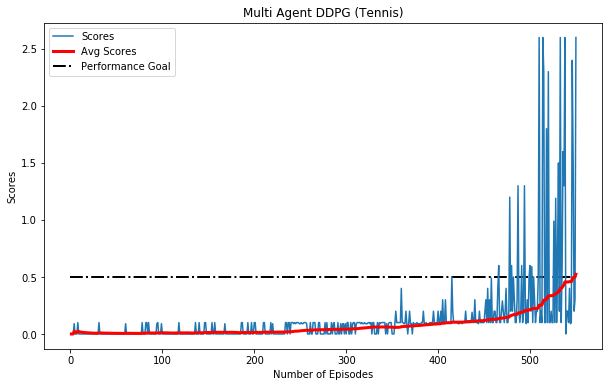

In [6]:
index = [i+1 for i in range(len(maddpg_scores))]
plt.figure(figsize=(10,6))
plt.plot(index, maddpg_scores, label='Scores')
plt.hlines(0.5, -1, len(maddpg_scores)+1, colors = 'k', linestyle='dashdot',
            linewidth=2, label='Performance Goal')
plt.plot(index, maddpg_avg_scores, 'r', linewidth=3, label='Avg Scores')
plt.title('Multi Agent DDPG (Tennis)')
plt.xlabel('Number of Episodes')
plt.ylabel('Scores')
plt.axis('tight')
plt.legend()
plt.savefig('figures/maddpg_scores.png')
plt.show()

#### 4. Discussion and Observations

The plots shown above suggest that the MADDPG is successful in completing the environment. Unlike the previous projects in which the agent has shown consistent climb in scores, this method does seem to be oscillating a lot at the beginning of the training phase. 

Rather than concluding that the agents are unable to learn consistently, however, it is more likely that the agents are lacking in terms of positive feedback in episode 0 to 300. Most of the scores obtained during this period are mostly 0s. This caused problem for the agents to learn in a timely manner. However, once the number of scores above 0 starts to populate the plot, the agents show a significant increase in scores starting from around episode 350 which eventually shoots up to 2.5 or even more after 500 episodes.  

In the process of completing the project, numerous combinations of hyperparameters were implemented for DDPG. Among 10 or so combinations, these hyperparameters were found to be the most optimal:

1. noise_weight = 1.0
2. noise_min = 0.1
3. noise_decay = 0.997
4. gamma = 0.99
5. tau = 0.01
6. learning rate
    - 0.0001 for Actor
    - 0.0003 for Critic
7. Deep QNetwork:
    - hidden_layer_1 = 128, with ReLU
    - hidden_layer_2 = 128, with ReLU
    - output_layer
        - tanh activation function for Actor
        - no activation function for Critic
8. targetUpdateNet = 1
9. num_update = 1
10. noise_update = 1
11. seed = 0

It is crucial to note that this method can be significantly improved by finding a methodical solution to sampling the possible actions at the beginning of the training phase more effectively.

One limiting factor in exploring all of these hyperparameters is definitely the time it takes to train the agent. Therefore, the model can be improved further by either tweaking the DDPG Agent's hyperparameters or the architecture of the neural network itself, e.g. learning rate, number of hidden layers, number of neurons per hidden layer, activation function (LeakyReLU instead of ReLU), etc.

In [7]:
env.close()